# Random Forest

In [ ]:
#!pip install imblearn

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import RandomOverSampler, SMOTE

from src import rf_utils

## UDF

## Import Data

In [8]:
accidents = pd.read_csv('data/accidents.csv', index_col=0)
accidents.head()

,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,is_non_functioning_device,has_no_controls,is_day,is_evening,is_morning,is_night,is_fall,is_spring,is_summer,is_winter
0,JC343143,07/10/2019 05:56:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,ONE-WAY,NaN,...,0,1,1,0,0,0,0,0,1,0
5,JC194776,03/21/2019 10:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,4.0,...,0,0,0,0,0,1,0,1,0,0
6,JB200478,03/26/2018 02:23:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,NOT DIVIDED,NaN,...,0,1,1,0,0,0,0,1,0,0
10,JB415436,08/30/2018 05:45:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,...,0,0,1,0,0,0,0,0,1,0
11,JC301403,06/11/2019 08:40:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,...,0,0,0,0,1,0,0,0,1,0


## Process Data for Model

In [9]:
X = accidents[['is_pedestrian',
               'has_stop_sign_or_traffic_light',
               'is_parked',
               'has_no_controls',
               'is_cyclist',
               'POSTED_SPEED_LIMIT',
               'is_night',
               'is_winter',
               'is_fall',
               'is_weekend',
               'is_clear_weather',
               'is_rain',
               'is_evening']]



y = accidents['is_fatal_or_incap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [10]:
oversampler = RandomOverSampler(sampling_strategy=0.75, random_state=3)
#oversampler = SMOTE(sampling_strategy=0.5, random_state=3)

X_over, y_over = oversampler.fit_resample(X_train.to_numpy(), y_train.to_numpy())

## Hyperparameter Tuning

In [11]:
n_features = X.shape[1]

n_estimators = [10, 50, 100]
max_features = [2, int(np.sqrt(n_features)), n_features // 2, n_features]
max_depth = [2, 3, 4]
params_grid = dict(n_estimators=n_estimators,
                   max_features=max_features,
                   max_depth=max_depth)

In [12]:
rf = RandomForestClassifier()

clf = GridSearchCV(rf, params_grid, cv=5, verbose=0, scoring='recall')

best_model = clf.fit(X_over, y_over)

In [13]:
print('Optimal # of Estimators: ', best_model.best_estimator_.get_params()['n_estimators'])
print('Optimal # of Features per Node: ', best_model.best_estimator_.get_params()['max_features'])
print('Max. Depth of Tree: ', best_model.best_estimator_.get_params()['max_depth'])

Optimal # of Estimators:  10
Optimal # of Features per Node:  13
Max. Depth of Tree:  4


### Train and Predict

In [14]:
n_estimators = 10
max_features = 13
max_depth = 4

rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, random_state=3)
rf.fit(X_over, y_over)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]


cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('\n')
print('Recall (Scores FN): ', round(recall_score(y_test, y_pred), 4))
print('Precision (Scores FP): ', round(precision_score(y_test, y_pred), 4))
print('AUC Score: ', round(roc_auc_score(y_test, y_prob), 4))

[[49429  8121]
 [  566   499]]


Recall (Scores FN):  0.4685
Precision (Scores FP):  0.0579
AUC Score:  0.7106


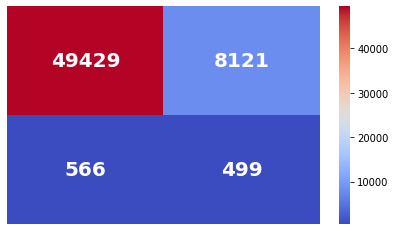

In [15]:
plt.figure(figsize=(7,4))
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, annot_kws={'size': 20, 'fontweight':'bold'}, fmt='d',
                 xticklabels=False, yticklabels=False);
#plt.savefig('img/cf_matrix.png', bbox_inches='tight')

### Permutation Importance

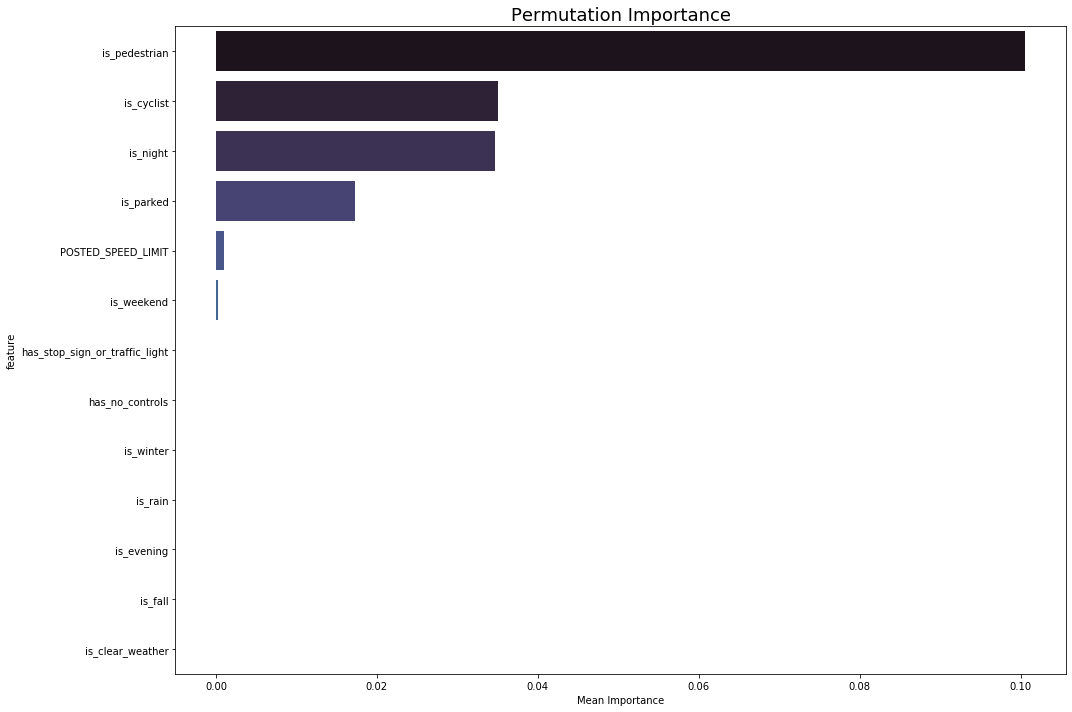

In [16]:
rf_utils.calculate_and_plot_permutation_importance(rf, X_over, y_over, 20, 3, (15,10), 16, X_train.columns)